# Algorítmo de limpieza de potencia aparente de Circuitos

El presente algorítmo permitirá obtener valores de potencia aparente validada para almacenarla en el DWH, la estampa de tiempo de la validación es de 1 minuto.

### Pasos a seguir durante el proceso:

    - Limpieza de outliers con el Método: Local Outlier Factor (LOF)
    - Aplicación del algoritmo de validación de máximos y mínimos
    - Almacenamiento de los datos validados en el DWH

### Limpieza de outliers con el Método: Local Outlier Factor (LOF)

Utilizaremos la biblioreca **sklearn** la cual tiene listo el algoritmo LOF para ser implementado.

In [1]:
### Importación de clases y paquetes

from GetCircuitos import GetCircuitos
from pyspark.sql.functions import to_timestamp, col, regexp_replace
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Obtención de los datos de Circuitos desde el HDFS ( POTENCIA DESTINO)

In [2]:
# Datos de entrada

fecha_inicio = datetime.datetime.strptime('2019-10-10 00:00', '%Y-%m-%d %H:%M')
fecha_fin = datetime.datetime.strptime('2019-10-10 23:59', '%Y-%m-%d %H:%M')
circuito = 'GUO138VIC1'
dimension = 'Potencia Aparente'

# Datos De circuitos (DataFrame Pyspark)

getCircuitos = GetCircuitos(TableName = '', FileName='circuitos_destino_*')
circuitosDestino = getCircuitos.GetDataDestino(fecha_inicio,fecha_fin,circuito)
print(circuitosDestino.columns)
circuitosDestino.select('circuito','TagPotenciaDestino').distinct().show(truncate=False)
tag = circuitosDestino.select('TagPotenciaDestino').distinct().first()[0]

# Datos a pandas dataframe

datosDestino = circuitosDestino.toPandas().set_index('Fecha')

['Id', 'circuito', 'Potencia', 'Calidad', 'TagCalidadDestino', 'TagPotenciaDestino', 'Fecha', 'LimMaxOperacion', 'LimOperacionContinuo', 'LimTermico', 'NumCircuitos']
+----------+-------------------------------+
|circuito  |TagPotenciaDestino             |
+----------+-------------------------------+
|GUO138VIC1|VICENTIN138GUALO_S.LINEA_CAL.AV|
+----------+-------------------------------+



#### Definición del Algoritmo LOF, salida de datos outliers y datos limpios

In [3]:
# Método LOF

def limpiar_outliers(datos):
    datos_totales = datos.copy()
    lof = LocalOutlierFactor(n_neighbors=5,contamination = 0.1)
    y_pred = lof.fit_predict(datos_totales)  
    mascara = y_pred == -1
    outliers = datos_totales[mascara]
    datos_totales = datos_totales[~mascara]
    return outliers, datos_totales

#### Aplicación del Algoritmo LOF

In [4]:
# Limpieza de datos

datos = datosDestino[['Id','Potencia']].copy()
outliers, datos_limpios = limpiar_outliers(datos)

#### Descripción de los datos obtenidos

In [5]:
# Descripcón de los datos de salida

print(datos.describe())
print('================================= Datos')
print(outliers.describe())
print('================================= Ouliers')
print(datos_limpios.describe())
print('================================= Datos Limpios')

          Potencia
count  8049.000000
mean      9.296076
std       3.149702
min       2.058689
25%       6.422241
50%       9.587813
75%      11.943588
max      15.242789
================================= Datos
         Potencia
count  805.000000
mean     9.454369
std      3.137660
min      2.567595
25%      6.584451
50%     10.023093
75%     12.100787
max     15.051916
================================= Ouliers
          Potencia
count  7244.000000
mean      9.278485
std       3.150762
min       2.058689
25%       6.415750
50%       9.516604
75%      11.925270
max      15.242789
================================= Datos Limpios


#### Gráfico para Visualizar los resultados

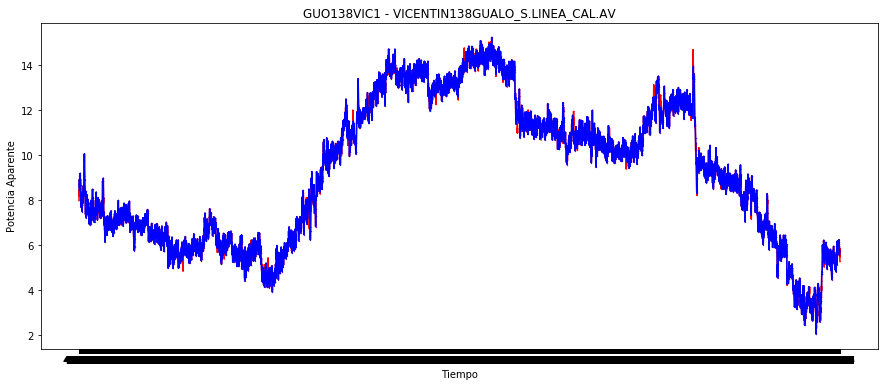

In [6]:
# Presentación de datos sin outliers

plt.plot(datos['Id'],datos['Potencia'],color="red",markersize=0.5,marker='.')
plt.plot(datos_limpios['Id'],datos_limpios['Potencia'],color="blue",markersize=0.5,marker='.')
plt.title(circuito+' - '+tag)
plt.xlabel('Tiempo')
plt.ylabel(dimension)
plt.show()

#### Gráfico BOXPLOT para visualizar los outliers

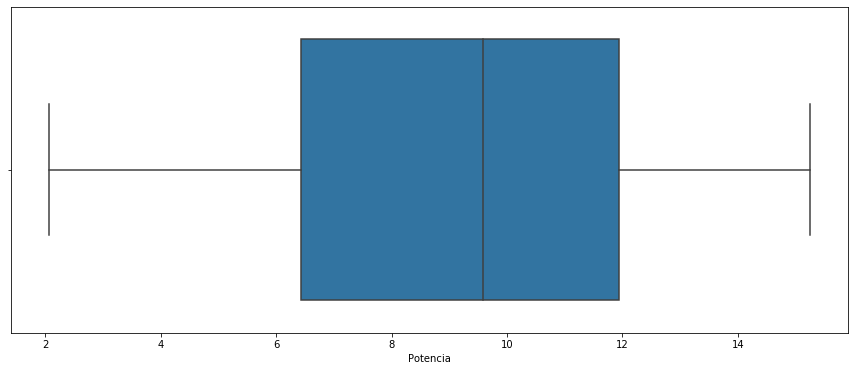

In [7]:
# Diagrama de cajas

sns.boxplot(datos['Potencia'])